In the name of god

**CNN Project - CIFAR Classification**

 **By: HeliaSadat Hashemipour**

In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz 
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 219MB/s]


**CIFAR_10**

In this issue, we want to manipulate 10-CIFAR database images. This database is a smaller version of the CIFAR-100 database, which is limited to images from 10 different categories
The dimensions of the images in this database are 32 (length (in 32) width (in 3) RGB color channels.
One of the most important steps in teaching artificial intelligence models is to prepare and pre-process the data so that it enters the model in the appropriate format. In this regard, a more complete explanation is given below.
Here, we first need to convert the grayscale color images to gray in a step after processing, after which we will have 32 by 32 images.
The input layer of the network has 32 * 32 = 1024 neurons, each of which shows the brightness of a pixel as an int number from 0 to 255.
Here, to reduce the computational volume, we use only the images of the first 4 classes of this database. As a result, our output layer will contain 4 neurons. The neuron with the highest amount of activation is selected as the hand detected by our model.
For this neural network, we consider two hidden layers, each of which has 16 neurons.
So the structure of our neural network will be as follows:

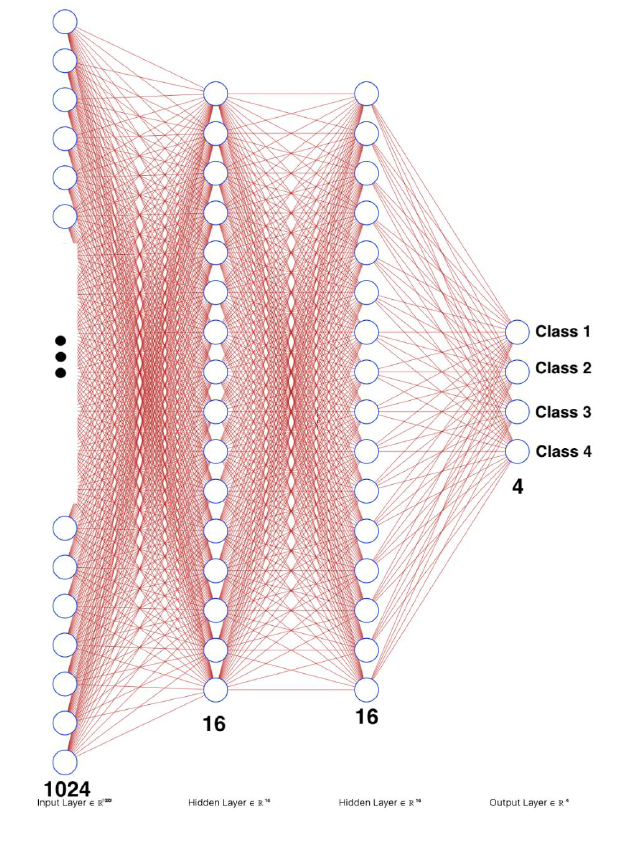

# Step One

imports library

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import timeit
import cv2 as cv
import random
import matplotlib.image as mpimg

load datasets (here as the prereport mentioned we need the first 4 datasets)

In [3]:
test1 = glob.glob("/content/CIFAR10/test/airplane/*.jpg")
train1 = glob.glob("/content/CIFAR10/train/airplane/*.jpg")
test2 = glob.glob("/content/CIFAR10/test/automobile/*.jpg")
train2 = glob.glob("/content/CIFAR10/train/automobile/*.jpg")
test3 = glob.glob("/content/CIFAR10/test/bird/*.jpg")
train3 = glob.glob("/content/CIFAR10/train/bird/*.jpg")
test4 = glob.glob("/content/CIFAR10/test/cat/*.jpg")
train4 = glob.glob("/content/CIFAR10/train/cat/*.jpg")

Read all the planes, cars, birds and cats in an array.

In [4]:
def readImage(images):
    cv_img = list()
    for img in images:
      n = cv.imread(img)
      n = n[:,:, ::-1]
      cv_img.append(n)
    return cv_img

class1=['airplane','automobile','bird','cat']
img_train = list()
img_test = list()
for classs in class1:
   trainn = mpimg.imread(f'./CIFAR10/train/{classs}/0000.jpg')
   testt = mpimg.imread(f'./CIFAR10/test/{classs}/0000.jpg')
   img_train.append(trainn)
   img_test.append(testt)


test_data = np.asarray(readImage(test1)+readImage(test2)+readImage(test3)+readImage(test4))
train_data = np.asarray(readImage(train1)+readImage(train2)+readImage(train3)+readImage(train4))


Save lable of this datasets in separate matrix for test and train.(use one-hot method).

In [5]:
def matrix_testLable():
  label=np.zeros(16000,)
  label=label.reshape(4000,4)   
  for i in range(0,4000):
      if(i<1000):
        label[i,0] = 1
      elif(i<2000):
        label[i,1] = 1
      elif(i<3000):
        label[i,2] = 1
      else:
        label[i,3] = 1
  return label


def matrix_trainLable():
  label=np.zeros(80000, )
  label=label.reshape(20000,4)   
  for i in range(0,20000):
      if(i<5000):
        label[i,0] = 1
      elif(i<10000):
        label[i,1] = 1
      elif(i<15000):
        label[i,2] = 1
      else:
        label[i,3] = 1
  return label

test_label = matrix_testLable()
train_label = matrix_trainLable()

Implement activation functions (sigmoid) and needed function tht related to  activation functions for implementing other sections.

In [6]:
def sigmoid(x):
    return 1 / (1 + (np.exp(-1 * x)))

def sigmoid_deriv(x):
    x = 1 / (1 + np.exp(-1 * x))
    result = x * (1 - x)
    return result

def vector_d(m):
    f = np.vectorize(sigmoid_deriv)
    return f(m)

Converting the image to gray to reduce computational complexity.(this code is exists exactly in prereport).

In [7]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

test_data = rgb2gray(test_data)
train_data = rgb2gray(train_data)

**normalizing**

Large input values can reduce the size of the gradient and thus the speed of learning. To do this, divide the data by 255 and divide it by zero to one.

In [8]:
test_data = (test_data/255)
train_data =(train_data/255)

**flat data**

We have 1024 neurons in the network input layer, so the network input data needs to be in the form of a vector with a size of 1024.

In [9]:
test_data = test_data.reshape(-1,1024)
train_data = train_data.reshape(-1,1024)

**shuffle data**

Shuffle our data matrices before starting the training.

In [10]:
def shuffledData(a, b):
    if len(a) == len(b):
      p = np.random.permutation(len(a))
    return (a[p], b[p])


test_data , test_label = shuffledData(test_data, test_label)
train_data , train_label = shuffledData(train_data, train_label)

# Second Step

random the weight and bias of layers

In [11]:
# allocate W matrix and vector bias for each layer.intialize W from standard normal distribution and bias=0 for each layer
def initialize():
  w0 = np.random.normal(size=(16,1024))
  w1 = np.random.normal(size=(16, 16))
  w2 = np.random.normal(size=(4, 16))
  b0 = np.zeros((16, 1))
  b1 = np.zeros((16, 1))
  b2 = np.zeros((4, 1))
  w = [w0, w1, w2]
  bias = [b0, b1, b2]

  return w,bias

Implementing the following formula on each layer:



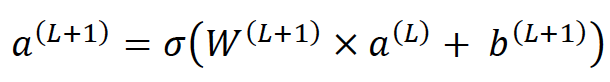

In [14]:
# allocate W matrix and vector bias for each layer.intialize W from standard normal distribution and bias=0 for each layer
w0 = np.random.normal(size=(16,1024))
w1 = np.random.normal(size=(16, 16))
w2 = np.random.normal(size=(4, 16))
b0 = np.zeros((16, 1))
b1 = np.zeros((16, 1))
b2 = np.zeros((4, 1))
 
W,b = initialize()

def guess(m):
    maximum = -99999
    index = 0
    for i in range(len(m)):
        if m[i] > maximum:
            maximum = m[i]
            index = i
    return index

#separate the 200 data  of the train set, and after initializing the matrix of weights with normal random numbers and biases in the form of all-zero vectors, 
#calculate the output of this 200 data. Should be done as described previously. 
#Finally, in the last layer, the neuron with the highest value
#Accuracy (model) Report the equivalent of the number of manually recognized photos divided by the total number of photos.
# It is considered as model recognition, which is in fact equivalent to the corresponding neuron.
def feedforward(weight0, weight1, weight2, bias0, bias1, bias2):
    counter = 0
    for i in range (0,200):
    #activation function is sigmoid
     new_data = train_data[i].reshape(-1,1)
     sigmoid_y = sigmoid(weight0 @ new_data + bias0)
     sigmoid_z = sigmoid(weight1 @ sigmoid_y + bias1)
     sigmoid_c = sigmoid(weight2 @ sigmoid_z + bias2)

     if guess(sigmoid_c) == guess(train_label[i]):
       counter = counter + 1

    print("Accuracy: "+str((counter/200)*100)+"%")

feedforward(W[0], W[1], W[2], b[0], b[1], b[2])

Accuracy: 25.5%



Accuracy is very low in this step, because we just feedforward the network and didn't back propagate.
Due to the fact that the learning process has not progressed, we anticipate an accuracy of roughly 25%.



---



# Third Step :Backpropagation with for loops

here we have to intialize the train_set and test_set

Stick each traine with its label

In [12]:
train_set = list()
test_set = list()
train_range = train_label.T.shape[1]
test_range = test_label.T.shape[1]

for i in range(0 , train_range):
  train_set.append((train_data.T[:, i].reshape(1024, 1), train_label.T[:, i].reshape(4, 1)))

for i in range(0,test_range):
  test_set.append((test_data[i, :].T.reshape(1024, 1), test_label[i, :].T.reshape(4, 1)))

Sum of squared errors (SSE) was used as a cost function:


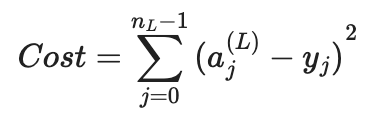



Backpropagation without vectorization:
*Last layer derivatives:*

Weight:

By applying the chain rule, the following formulas wil be obtained:
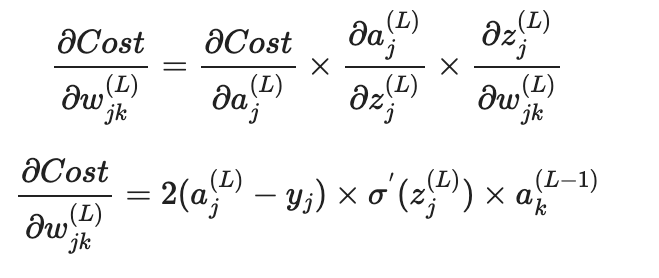


Bias:

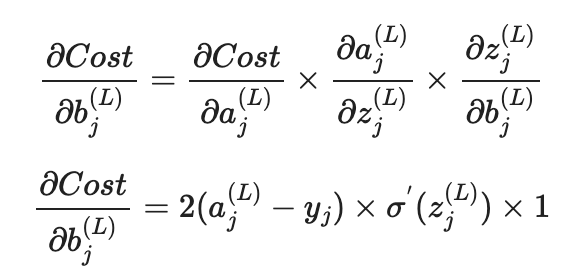


Activation:

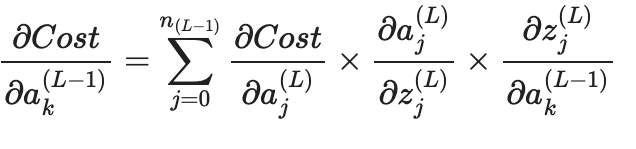

*Other layers derivatives:*
Weight:

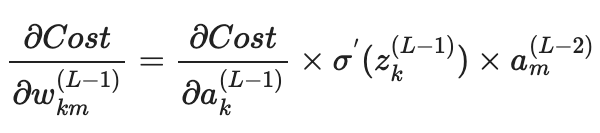


Bias:

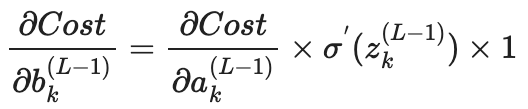


Activation:

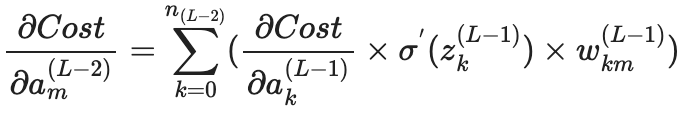

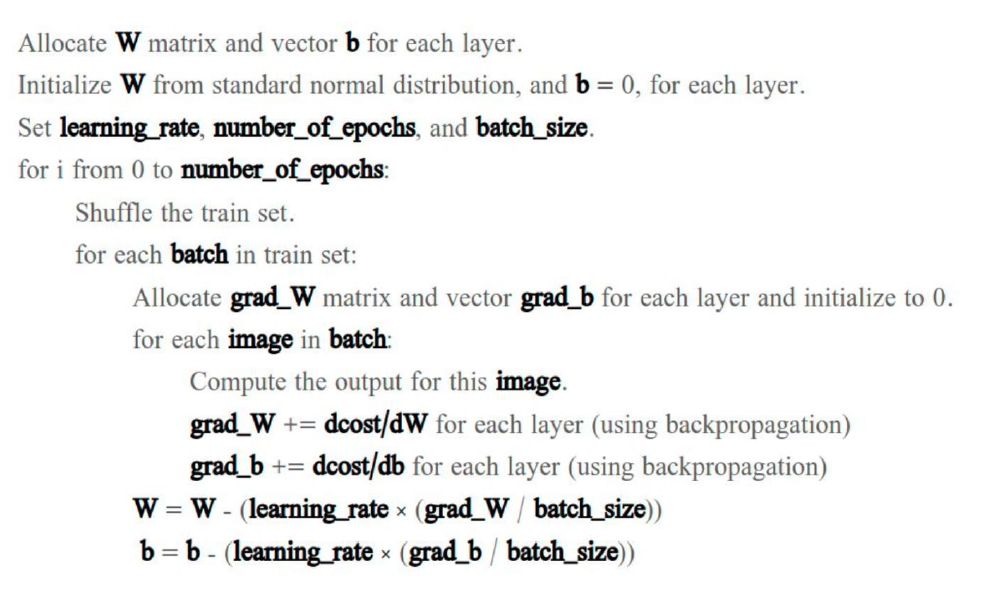Claculate backprpagation and Train process using Batch Gradient Descent 

And also calculate the average cost of samples in each epoch and plot at the end. These averages are expected to decline per epoch.

Runtime of the program is 90.15610837936401 seconds
Accuracy:37.0%


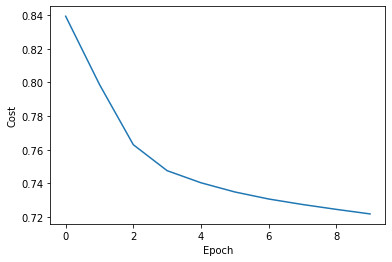

In [ ]:
#hyperprameteers
epochsNumb = 10
batch_size = 16
batch_num = 20
learning_rate = 0.3
costs = list()
train = train_set[:200]
test = test_set[:200]

# Compute gradients of wights and biases
def backpropagation(weight0, weight1, weight2, bias0, bias1, bias2):
  start = time.time()
  for i in range(0 , epochsNumb):
    batches = [train_set[i : i + batch_size] for i in range(0, 200, batch_size)]
    # based on Stochastic Gradient Descent
    for batch in batches:
    # allocate grad_w matrix and vector grad_b for each layer and initialize to 0.
        grad_w0 = np.zeros((16, 1024))
        grad_w1 = np.zeros((16, 16))
        grad_w2 = np.zeros((4, 16))
        grad_bias0 = np.zeros((16, 1))
        grad_bias1 = np.zeros((16, 1))
        grad_bias2 = np.zeros((4, 1))
        

        for image, label in batch:
          #for simplyfing the calculation i make the a(i) layers like this
            a1 = sigmoid(weight0 @ image + bias0)
            a2 = sigmoid(weight1 @ a1 + bias1)
            a3 = sigmoid(weight2 @ a2 + bias2)
            # z1 = (weight0 @ image) + bias0
            # a1 = np.asarray([sigmoid(j) for j in z1]).reshape((16, 1))
            # z2 = (weight1 @ a1) + bias1
            # a2 = np.asarray([sigmoid(j) for j in z2]).reshape((16, 1))
            # z3 = (weight2 @ a2) + bias2
            # a3 = np.asarray([sigmoid(j) for j in z3]).reshape((4, 1))

            # base on the formula we implemented each layer
            # Last layer
            for x in range(4):
                for y in range(16):
                    grad_w2[x, y] +=  a2[y, 0] * (1 - a3[x, 0])  * a3[x, 0]  * (2 * a3[x, 0] - 2 * label[x, 0])
            
        
            for x in range(4):
                    grad_bias2[x, 0] +=  a3[x, 0] * (1 - a3[x, 0]) * (2 * a3[x, 0] - 2 * label[x, 0]) 
            

            # 3rd hidden layer
            grad_a2 = np.zeros((16, 1))
            for k in range(16):
                for j in range(4):
                    grad_a2[k, 0] += weight2[j, k] * a3[j, 0] * (1 - a3[j, 0]) * (2 * a3[j, 0] - 2 * label[j, 0]) 
            
            
            for x in range(16):
                for y in range(16):
                    grad_w1[x, y] += grad_a2[x, 0] * a1[y, 0] * a2[x,0] * (1 - a2[x, 0]) 
            
            
            for x in range(16):
                    grad_bias1[x, 0] += a2[x, 0] * (1 - a2[x, 0]) * grad_a2[x, 0] 
                    
            # 2nd hidden layer
            grad_a1 = np.zeros((16, 1))
            for m in range(16):
                for k in range(16):
                    grad_a1[m, 0] += weight1[k, m] * grad_a2[k, 0] * a2[k, 0] * (1 - a2[k, 0]) 
            
            
            for x in range(16):
                for y in range(1024):
                    grad_w0[x, y] += grad_a1[x, 0] * a1[x,0] * (1 - a1[x, 0]) * image[y, 0]
            
            for x in range(16):
                    grad_bias0[x, 0] +=  a1[x, 0] * (1 - a1[x, 0]) * grad_a1[x, 0] 
                    
      # update the w
      # update the b
        weight2 -= (learning_rate * (grad_w2 / batch_size))
        weight1 -= (learning_rate * (grad_w1 / batch_size))
        weight0 -= (learning_rate * (grad_w0 / batch_size))
        
        bias2 -= (learning_rate * (grad_bias2 / batch_size))
        bias1 -= (learning_rate * (grad_bias1 / batch_size))
        bias0 -= (learning_rate * (grad_bias0 / batch_size))
    
    # cost
    cost = 0
    correct_guess = 0
    for train_data in train_set[:200]:
        a0 = train_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(train_data[1]):
          correct_guess =  correct_guess + 1

        # Compute SSE cost
        for j in range(0,4):
            cost = cost + ((a3[j, 0] - train_data[1][j,  0]) ** 2)
            
    costs.append(cost / 200)  
  stop = time.time()
  epoch_size = [x for x in range(0,10)]
  plt.plot(epoch_size, costs)
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  print(f"Runtime of the program is {stop - start} seconds")
  print("Accuracy:" + str((correct_guess / 200)*100)+"%")   



backpropagation(W[0], W[1], W[2], b[0], b[1], b[2])

As we can see we printed the accuracy and the runtime of the program (as the prereport said the accuray of 30% is accetable, As we know, random network initialization can affect the network training process to some extent, and the accuracy of our model may be a little over 30%) but the runtime of the program is too long (around 1.5min) 



---



# Fourth Step: Vectorization

So far we have only worked with the first 200 datasets because the current training process is too long and not optimal for network learning. To solve this problem, we use a concept called vectorization. This concept means that instead of using for on devices, we implement the operation in the form of matrix operations.
The main reason for this acceleration in computation is that matrix operations can be well parallelized and performed in multicast.
Processors also have instructions for working with big data and vectors that run more efficiently.

**Backpropagation with vectorization :**

Runtime of the program is 1.2160513401031494 seconds
Accuracy:76.5%


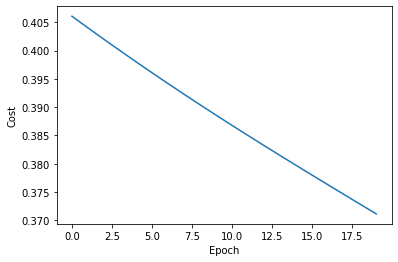

In [23]:
#hyperparameters
epochsNumb = 20
batch_size = 16
batch_num = 20
learning_rate = 0.3
costs = list()
train = train_set[:200]
test = test_set[:200]

def vectorization(weight0, weight1, weight2, bias0, bias1, bias2):
  start = time.time()
  for i in range(0 , epochsNumb):
    batches = [train_set[x : x + batch_size] for x in range(0, 200, batch_size)]
    # based on Stochastic Gradient Descent
    for batch in batches:
    # allocate grad_w matrix and vector grad_b for each layer and initialize to 0.
        grad_w0 = np.zeros((16, 1024))
        grad_w1 = np.zeros((16, 16))
        grad_w2 = np.zeros((4, 16))
        grad_bias0 = np.zeros((16, 1))
        grad_bias1 = np.zeros((16, 1))
        grad_bias2 = np.zeros((4, 1))
        

        for image, label in batch:
          #for simplyfing the calculation i make the a(i) layers like this
            a1 = sigmoid(weight0 @ image + bias0)
            a2 = sigmoid(weight1 @ a1 + bias1)
            a3 = sigmoid(weight2 @ a2 + bias2)
            # z1 = (weight0 @ image) + bias0
            # a1 = np.asarray([sigmoid(j) for j in z1]).reshape((16, 1))
            # z2 = (weight1 @ a1) + bias1
            # a2 = np.asarray([sigmoid(j) for j in z2]).reshape((16, 1))
            # z3 = (weight2 @ a2) + bias2
            # a3 = np.asarray([sigmoid(j) for j in z3]).reshape((4, 1))

            # base on the formula we implemented each layer
            # Last layer
            grad_w2 += (2 *  (a3) * (1 - a3) * (a3 - label)) @ np.transpose(a2)
            grad_bias2 += ( 2 *  (a3) * (1-a3) * (a3- label) )
            

            # 3rd layer
            delta3 = np.zeros((16, 1))
            delta3 += np.transpose(weight2) @ (2 *  (a3) * (1-a3) * (a3- label)) 
            grad_w1 += ( (a2)* (1-a2) * delta3) @ np.transpose(a1)   
            grad_bias1 +=  (a2) * (1-a2) * delta3 
                    
            # 2nd layer
            delta2 = np.zeros((16, 1))
            delta2 += np.transpose(weight1) @ ( (a2) * (1-a2) * delta3 )

            grad_w0 += ( (a1) * (1-a1) * delta2 )  @ np.transpose(image)
            
            grad_bias0 += ( (a1) * (1-a1) * delta2 )
        
      # update the w
      # update the b
        weight2 -= (learning_rate * (grad_w2 / batch_size))
        weight1 -= (learning_rate * (grad_w1 / batch_size))
        weight0 -= (learning_rate * (grad_w0 / batch_size))
        
        bias2 -= (learning_rate * (grad_bias2 / batch_size))
        bias1 -= (learning_rate * (grad_bias1 / batch_size))
        bias0 -= (learning_rate * (grad_bias0 / batch_size))
    
    # cost based on SSE
    cost = 0
    correct_guess = 0
    for train_data in train:
        a0 = train_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(train_data[1]):
          correct_guess =  correct_guess + 1

        for j in range(0,4):
            cost = cost + ((a3[j, 0] - train_data[1][j,  0]) ** 2)
            
    costs.append(cost / 200)  
  stop = time.time()
  epoch_size = [i for i in range(0,20)]
  plt.plot(epoch_size, costs)
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  print(f"Runtime of the program is {stop - start} seconds")
  print("Accuracy:" + str((correct_guess / 200)*100)+"%") 


vectorization(w0, w1, w2, b0, b1, b2)

For this section, we designed our code to run 10 times from the beginning of your code.

As we can see we printed the accuracy and the runtime of the program.the runtime of the program is is well ,though (1 sec) .
in previous step it was also 90 times.



---



# Fifth Step

train and set backpropagaition function with epoch number 40

the values that mentioned in prereport

In [ ]:
epochsNumb = 40
batch_size = 16
batch_num = 20
learning_rate = 0.3
costs = list()
train = train_set[:200]
test = test_set[:200]

Runtime of the program is 319.1710398197174 seconds
Accuracy of train:69.0%
Accuracy of test:41.0%


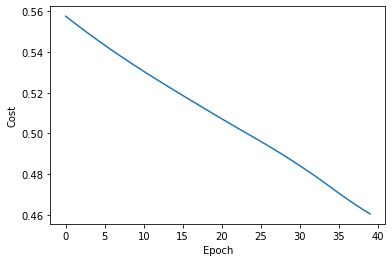

In [ ]:

# Compute gradients of wights and biases
def backpropagation_t(weight0, weight1, weight2, bias0, bias1, bias2):
  start = time.time()
  for i in range(0 , epochsNumb):
    batches = [train_set[i : i + batch_size] for i in range(0, 200, batch_size)]
    # based on Stochastic Gradient Descent
    for batch in batches:
    # allocate grad_w matrix and vector grad_b for each layer and initialize to 0.
        grad_w0 = np.zeros((16, 1024))
        grad_w1 = np.zeros((16, 16))
        grad_w2 = np.zeros((4, 16))
        grad_bias0 = np.zeros((16, 1))
        grad_bias1 = np.zeros((16, 1))
        grad_bias2 = np.zeros((4, 1))
        

        for image, label in batch:
          #for simplyfing the calculation i make the a(i) layers like this
            a1 = sigmoid(weight0 @ image + bias0)
            a2 = sigmoid(weight1 @ a1 + bias1)
            a3 = sigmoid(weight2 @ a2 + bias2)
            # z1 = (weight0 @ image) + bias0
            # a1 = np.asarray([sigmoid(j) for j in z1]).reshape((16, 1))
            # z2 = (weight1 @ a1) + bias1
            # a2 = np.asarray([sigmoid(j) for j in z2]).reshape((16, 1))
            # z3 = (weight2 @ a2) + bias2
            # a3 = np.asarray([sigmoid(j) for j in z3]).reshape((4, 1))

            # base on the formula we implemented each layer
            # Last layer
            for x in range(4):
                for y in range(16):
                    grad_w2[x, y] +=  a2[y, 0] * (1 - a3[x, 0])  * a3[x, 0]  * (2 * a3[x, 0] - 2 * label[x, 0])
            
        
            for x in range(4):
                    grad_bias2[x, 0] +=  a3[x, 0] * (1 - a3[x, 0]) * (2 * a3[x, 0] - 2 * label[x, 0]) 
            

            # 3rd hidden layer
            grad_a2 = np.zeros((16, 1))
            for k in range(16):
                for j in range(4):
                    grad_a2[k, 0] += weight2[j, k] * a3[j, 0] * (1 - a3[j, 0]) * (2 * a3[j, 0] - 2 * label[j, 0]) 
            
            
            for x in range(16):
                for y in range(16):
                    grad_w1[x, y] += grad_a2[x, 0] * a1[y, 0] * a2[x,0] * (1 - a2[x, 0]) 
            
            
            for x in range(16):
                    grad_bias1[x, 0] += a2[x, 0] * (1 - a2[x, 0]) * grad_a2[x, 0] 
                    
            # 2nd hidden layer
            grad_a1 = np.zeros((16, 1))
            for m in range(16):
                for k in range(16):
                    grad_a1[m, 0] += weight1[k, m] * grad_a2[k, 0] * a2[k, 0] * (1 - a2[k, 0]) 
            
            
            for x in range(16):
                for y in range(1024):
                    grad_w0[x, y] += grad_a1[x, 0] * a1[x,0] * (1 - a1[x, 0]) * image[y, 0]
            
            for x in range(16):
                    grad_bias0[x, 0] +=  a1[x, 0] * (1 - a1[x, 0]) * grad_a1[x, 0] 
                    
      # update the w
      # update the b
        weight2 -= (learning_rate * (grad_w2 / batch_size))
        weight1 -= (learning_rate * (grad_w1 / batch_size))
        weight0 -= (learning_rate * (grad_w0 / batch_size))
        
        bias2 -= (learning_rate * (grad_bias2 / batch_size))
        bias1 -= (learning_rate * (grad_bias1 / batch_size))
        bias0 -= (learning_rate * (grad_bias0 / batch_size))
    
    # cost
    cost = 0
    correct_guess = 0
    for train_data in train_set[:200]:
        a0 = train_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(train_data[1]):
          correct_guess =  correct_guess + 1

        # Compute SSE cost
        for j in range(0,4):
            cost = cost + ((a3[j, 0] - train_data[1][j,  0]) ** 2)
            
    costs.append(cost / 200)
    cnt2=0 
    for test_data in test:
        a0 = test_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(test_data[1]):
          cnt2 =  cnt2 + 1  

  stop = time.time()
  epoch_size = [x for x in range(0,40)]
  plt.plot(epoch_size, costs)
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  print(f"Runtime of the program is {stop - start} seconds")
  print("Accuracy of train:" + str((correct_guess / 200)*100)+"%") 
  print("Accuracy of test:" + str((cnt2 / 200)*100)+"%")    



backpropagation_t(W[0], W[1], W[2], b[0], b[1], b[2])

As we can see the accuracy of train and test is acceptable(based on the prereport) but the runtime is too long(around 6 min!!!!!!!)



---



train and set vectoriazation function with epoch number 40 

Runtime of the program is 2.7594285011291504 seconds
Accuracy of train:56.00000000000001%
Accuracy of test:42.0%


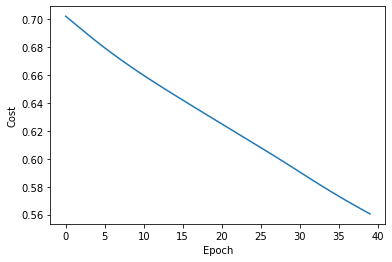

In [ ]:
def vectorization_t(weight0, weight1, weight2, bias0, bias1, bias2):
  start = time.time()
  costs = list()
  for i in range(0 , epochsNumb):
    batches = [train_set[j : j + batch_size] for j in range(0, 200, batch_size)]
    # based on Stochastic Gradient Descent
    for batch in batches:
    # allocate grad_w matrix and vector grad_b for each layer and initialize to 0.
        grad_w0 = np.zeros((16, 1024))
        grad_w1 = np.zeros((16, 16))
        grad_w2 = np.zeros((4, 16))
        grad_bias0 = np.zeros((16, 1))
        grad_bias1 = np.zeros((16, 1))
        grad_bias2 = np.zeros((4, 1))
        

        for image, label in batch:
          #for simplyfing the calculation i make the a(i) layers like this
            a1 = sigmoid(weight0 @ image + bias0)
            a2 = sigmoid(weight1 @ a1 + bias1)
            a3 = sigmoid(weight2 @ a2 + bias2)
            # z1 = (weight0 @ image) + bias0
            # a1 = np.asarray([sigmoid(j) for j in z1]).reshape((16, 1))
            # z2 = (weight1 @ a1) + bias1
            # a2 = np.asarray([sigmoid(j) for j in z2]).reshape((16, 1))
            # z3 = (weight2 @ a2) + bias2
            # a3 = np.asarray([sigmoid(j) for j in z3]).reshape((4, 1))

            # base on the formula we implemented each layer
            # Last layer
            grad_w2 += (2 *  (a3) * (1 - a3) * (a3 - label)) @ np.transpose(a2)
            grad_bias2 += ( 2 *  (a3) * (1-a3) * (a3- label) )
            

            # 3rd layer
            grad_a2 = np.zeros((16, 1))
            grad_a2 += np.transpose(weight2) @ (2 *  (a3) * (1-a3) * (a3- label)) 
            grad_w1 += ( (a2)* (1-a2) * grad_a2) @ np.transpose(a1)   
            grad_bias1 +=  (a2) * (1-a2) * grad_a2 
                    
            # 2nd layer
            grad_a1 = np.zeros((16, 1))
            grad_a1 += np.transpose(weight1) @ ( (a2) * (1-a2) * grad_a2 )

            grad_w0 += ( (a1) * (1-a1) * grad_a1 )  @ np.transpose(image)
            
            grad_bias0 += ( (a1) * (1-a1) * grad_a1 )
        
      # update the w
      # update the b
        weight2 -= (learning_rate * (grad_w2 / batch_size))
        weight1 -= (learning_rate * (grad_w1 / batch_size))
        weight0 -= (learning_rate * (grad_w0 / batch_size))
        
        bias2 -= (learning_rate * (grad_bias2 / batch_size))
        bias1 -= (learning_rate * (grad_bias1 / batch_size))
        bias0 -= (learning_rate * (grad_bias0 / batch_size))
    
    # calculating the cost
    cost = 0
    correct_guess = 0
    for train_data in train_set[:200]:
        a0 = train_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(train_data[1]):
          correct_guess =  correct_guess + 1
         
     # based on the SSE formula
        for j in range(0,4):
            cost = cost + ((a3[j, 0] - train_data[1][j,  0]) ** 2)
            
    costs.append(cost / 200) 
    cnt2 = 0 
    for test_data in test:
        a0 = test_data[0]
        a1 = sigmoid(weight0 @ a0 + bias0)
        a2 = sigmoid(weight1 @ a1 + bias1)
        a3 = sigmoid(weight2 @ a2 + bias2)
    
        if guess(a3) == guess(test_data[1]):
          cnt2 =  cnt2 + 1

  stop = time.time()
  epoch_size = [i for i in range(0,40)]
  plt.plot(epoch_size, costs)
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  print(f"Runtime of the program is {stop - start} seconds")
  print("Accuracy of train:" + str((correct_guess / 200)*100)+"%") 
  print("Accuracy of test:" + str((cnt2 / 200)*100)+"%")     


vectorization_t(W[0], W[1], W[2], b[0], b[1], b[2])

As we can see the accuracy of train and test is acceptable and the runtime is acceptable ,too.(2 sec) 